# Logistic regression for SMS spam classification

This project implements the logistic regression to create a spam classifier for SMS messages.

Each line of the data file `sms.txt`
contains a label---either "spam" or "ham" (i.e. non-spam)---followed
by a text message. Here are a few examples (line breaks added for readability):

    ham     Ok lar... Joking wif u oni...
    ham     Nah I don't think he goes to usf, he lives around here though
    spam    Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.
            Text FA to 87121 to receive entry question(std txt rate)
            T&C's apply 08452810075over18's
    spam    WINNER!! As a valued network customer you have been
            selected to receivea £900 prize reward! To claim
            call 09061701461. Claim code KL341. Valid 12 hours only.

To create features suitable for logistic regression, code is provided to do the following (using tools from the ``sklearn.feature_extraction.text``):

* Convert words to lowercase.
* Remove punctuation and special characters (but convert the \$ and
  £ symbols to special tokens and keep them, because these are useful for predicting spam).
* Create a dictionary containing the 3000 words that appeared
  most frequently in the entire set of messages.
* Encode each message as a vector $\mathbf{x}^{(i)} \in
  \mathbb{R}^{3000}$. The entry $x^{(i)}_j$ is equal to the
  number of times the $j$th word in the dictionary appears in that
  message.
* Discard some ham messages to have an
  equal number of spam and ham messages.
* Split data into a training set of 1000 messages and a
  test set of 400 messages.
  
The following section completed the following tasks: 

* Learn $\boldsymbol{\theta}$ by gradient descent
* Plot the cost history
* Make predictions and report the accuracy on the test set
* Test out the classifier on a few of your own text messages

# 1. Load and prep data

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import re
import matplotlib.pyplot as plt
import codecs

from logistic_regression import logistic, cost_function, gradient_descent
from sklearn.feature_extraction.text import CountVectorizer

# Preprocess the SMS Spam Collection data set
#  
#   https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection
# 
# From Dan Sheldon

numTrain    = 1000
numTest     = 494
numFeatures = 3000

np.random.seed(1)

# Open the file
f = codecs.open('sms.txt', encoding='utf-8')

labels = []    # list of labels for each message
docs   = []    # list of messages

# Go through each line of file and extract the label and the message
for line in f:
    l, d= line.strip().split('\t', 1)
    labels.append(l)
    docs.append(d)

# This function will be called on each message to preprocess it
def preprocess(doc):
    # Replace all currency signs and some url patterns by special
    # tokens. These are useful features.
    doc = re.sub('[£$]', ' __currency__ ', doc)
    doc = re.sub('\://', ' __url__ ', doc)
    doc = doc.lower() # convert to lower
    return doc


# This is the object that does the conversion from text to feature vectors
vectorizer = CountVectorizer(max_features=numFeatures, preprocessor=preprocess)

# Do the conversion ("fit" the transform from text to feature vector. 
#   later we will also "apply" the tranform on test messages)
X = vectorizer.fit_transform(docs)

# Convert labels to numbers: 1 = spam, 0 = ham
y = np.array([l == 'spam' for l in labels]).astype('int')

# The vectorizer returns sparse scipy arrays. Convert this back to a dense 
#   numpy array --- not as efficient but easier to work with
X = X.toarray()
m,n = X.shape

# Add a column of ones
X = np.column_stack([np.ones(m), X])

# 
# Now massage and split into test/train
# 
pos = np.nonzero(y == 1)[0]   # indices of positive training examples
neg = np.nonzero(y == 0)[0]   # indices of negative training examples

npos = len(pos)

# Create a subset that has the same number of positive and negative examples
subset = np.concatenate([pos, neg[0:len(pos)] ])

# Randomly shuffle order of examples
np.random.shuffle(subset)
      
X = X[subset,:]
y = y[subset]

# Split into test and train
train = np.arange(numTrain)
test  = numTrain + np.arange(numTest)

X_train = X[train,:]
y_train = y[train]

X_test  = X[test,:]
y_test  = y[test]

# Extract the list of test documents
test_docs = [docs[i] for i in subset[test]]

# Extract the list of tokens (words) in the dictionary
tokens = vectorizer.get_feature_names()

# 2. Train logistic regresion model

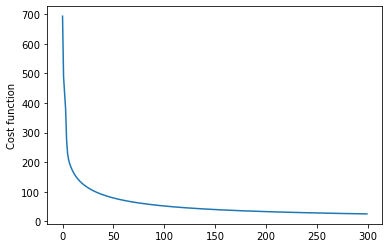

In [5]:
# X_train     contains information about the words within the training
#             messages. the ith row represents the ith training message. 
#             for a particular text, the entry in the jth column tells
#             you how many times the jth dictionary word appears in 
#             that message
#
# X_test      similar but for test set
#
# y_train     ith entry indicates whether message i is spam
#
# y_test      similar
#

m, n = X_train.shape

theta = np.zeros(n)

# YOUR CODE HERE: 
#  - learn theta by gradient descent
alpha = 0.005
iters = 300

gd = gradient_descent( X_train, y_train, theta, alpha, iters)
theta = gd[0]
J_history = gd[1]

#  - plot the cost history
J_x = range(0, iters)
plt.plot(J_x, J_history)
plt.ylabel("Cost function")
plt.show()

#  - tune step size and # iterations if necessary

# 3. Make predictions on test set

We can then use the model fit in the previous cell to make predictions on the test set and compute the accuracy (percentage of messages in the test set that are classified correctly). 

In [14]:
m_test, n_test = X_test.shape

# YOUR CODE HERE
#  - use theta to make predictions for test set
p = logistic(np.dot(X_test, np.transpose(theta)))
y_predict = np.round(p,0)

#  - print the accuracy on the test set---i.e., the precent of messages classified correctly
percentage = (np.sum(y_predict == y_test) / numTest).round(6)*100
print("Percentage of correctly classified training data: ", percentage, "%")

Percentage of correctly classified training data:  96.5587 %


# 4. Inspect model parameters

In [15]:
token_weights = theta[1:]

def reverse(a):
    return a[::-1]

most_negative = np.argsort(token_weights)
most_positive = reverse(most_negative)

k = 10

print('Top %d spam words' % k)
for i in most_positive[0:k]:
    print('  %+.4f  %s' % (token_weights[i], tokens[i]))

print('\nTop %d ham words' % k)
for i in most_negative[0:k]:
    print('  %+.4f  %s' % (token_weights[i], tokens[i]))


Top 10 spam words
  +2.8143  __currency__
  +2.2106  call
  +2.1241  text
  +2.0684  txt
  +1.8895  reply
  +1.7770  service
  +1.6672  150p
  +1.6297  ringtone
  +1.6045  mobile
  +1.5618  message

Top 10 ham words
  -1.4401  my
  -1.3702  so
  -1.2545  ok
  -1.1648  me
  -1.0856  later
  -1.0713  what
  -1.0656  ll
  -0.9892  come
  -0.9879  he
  -0.9204  still


The code above examines the model parameters for each word. Positive values are words that tend to be spam and negative values are words that tend to be ham.

The top 10 spam and ham words make sense, because they are indeed the words that frequently appear in spam & ham messages.

## 4.1 Make a prediction on new message

We can further play with some sample message and make predictions using the model. As shown below, the predictions do match our expectation for classifying the messages.

In [32]:
def extract_features(msg):
    x = vectorizer.transform([msg]).toarray()
    x = np.insert(x, 0, 1)
    return x

#  - try a few texts and predict whether they are spam or non-spam
msg1 = u"Test me back when you see this message"
x = extract_features(msg1)
p = logistic(np.dot(x, np.transpose(theta)))
y_predict = int(np.round(p,0))
print('Message 1:', "spam" if y_predict== 1 else "ham")

msg2 = u"selected to receivea £900 prize reward! To claim call 99999999. Claim code KL341. Or claim at website 900reward.com"
x = extract_features(msg2)
p = logistic(np.dot(x, np.transpose(theta)))
y_predict = int(np.round(p,0))
print('Message 2:', "spam" if y_predict== 1 else "ham")

Message 1: ham
Message 2: spam
